In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import time

import Featurizer as ft

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [27]:
df_train = pd.read_csv("../data/palabras.csv")

## Pre-processing

In [28]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [29]:
X_train_submit = X_train.copy()

In [30]:
import category_encoders as ce

OHE = ce.OneHotEncoder( handle_unknown='ignore', use_cat_names=True)
BE = ce.BinaryEncoder( handle_unknown='ignore')

In [31]:
X_train = ft.preprocess(X_train, OHE, BE, 'train')
X_test = ft.preprocess(X_test, OHE, BE, 'test')

--- 10.42476201057434 seconds ---
--- 4.778096914291382 seconds ---


In [32]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 80) y=(240000,)
Train shapes: X=(180000, 166) y=(180000,)
Test  shapes: X=(60000, 166)  y=(60000,)


## Feature Selection

In [12]:
#from sklearn.feature_selection import SelectKBest

In [13]:
#selection = SelectKBest(k=40)
#x_features = selection.fit_transform(X_train, y_train)
#columns = np.asarray(X_train.columns.values)
#support = np.asarray(selection.get_support())
#columns_with_support = columns[support]

In [14]:
#columns_with_support

## Training

In [34]:
features = X_train.columns
X_train.columns = list(range(0,X_train.shape[1]))
X_test.columns = list(range(0,X_test.shape[1]))

In [35]:
import lightgbm as lgb

model = lgb.LGBMRegressor(learning_rate=0.05,n_estimators=1500,num_leaves=15000,
                          max_depth=14,subsample=0.5,n_jobs=3,verbose=10)
model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=14,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1500, n_jobs=3, num_leaves=15000, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.5, subsample_for_bin=200000, subsample_freq=0,
              verbose=10)

In [36]:
start_time = time.time()
model.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 237.96403050422668 seconds ---


## Predicciones

In [37]:
ft.predecir(model, X_train, y_train, X_test, y_test)

Entrenamiento: 99.5026%
Testeo: 79.2592%.
Mean abs error: 565853.9552.


In [44]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':features,'y':importancia}

df_importancia = pd.DataFrame(d)

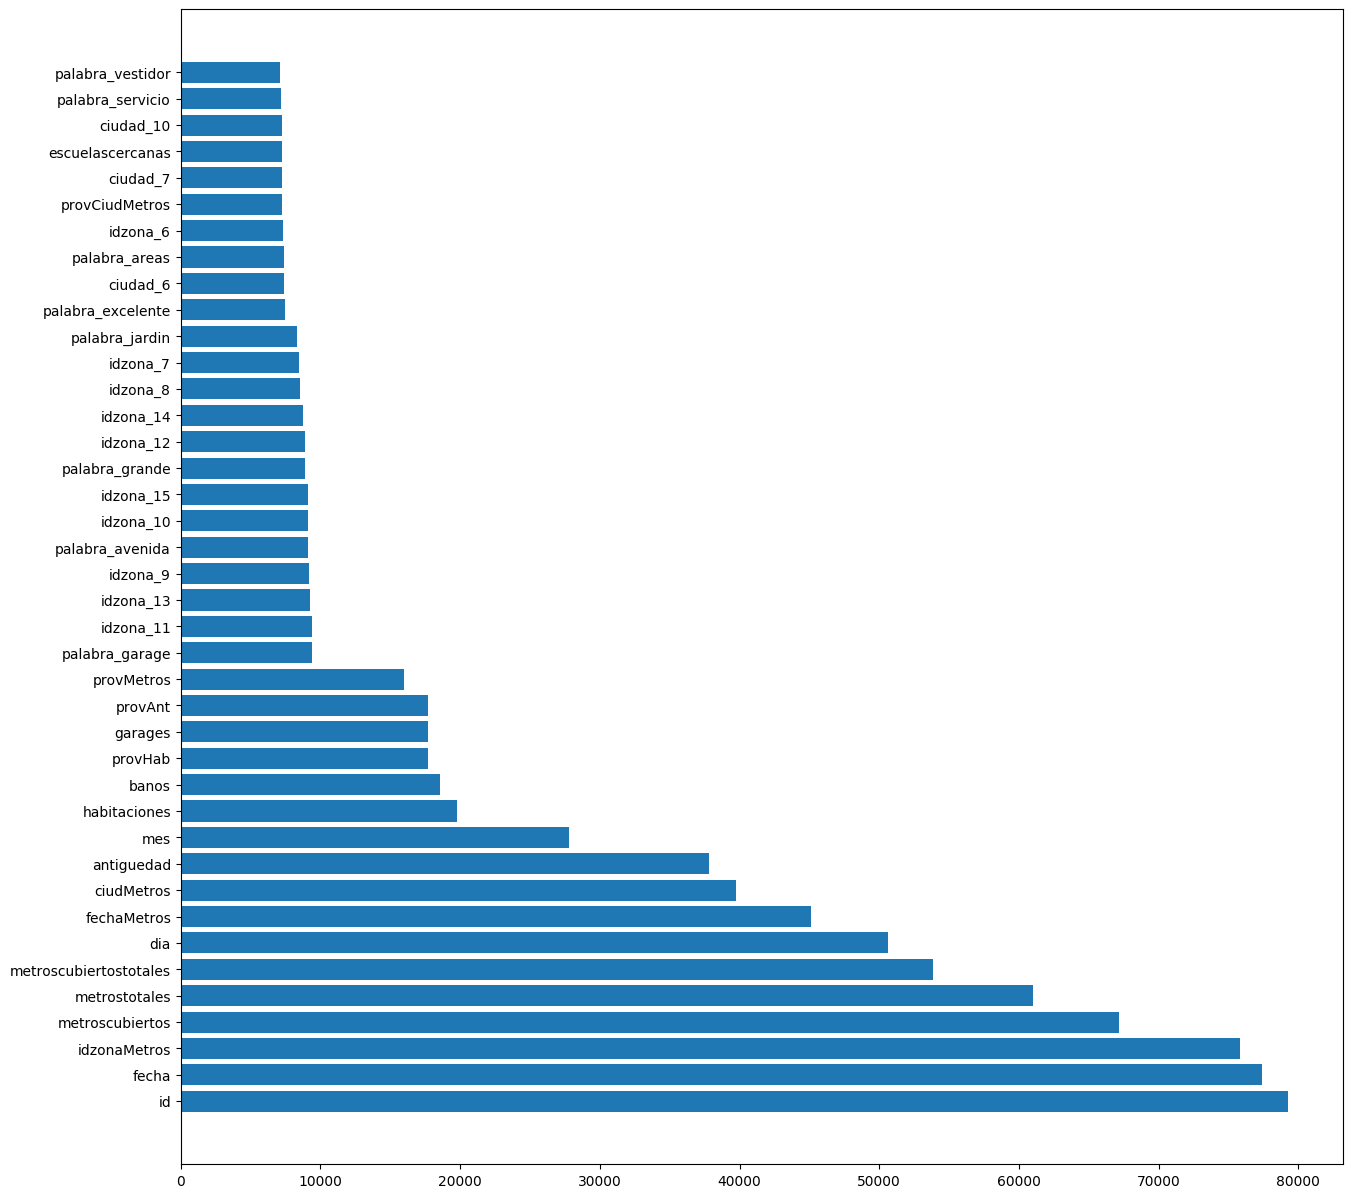

In [43]:
importancia = df_importancia.sort_values(by="y",ascending=False).head(40)
ax = plt.barh(importancia.x,importancia.y)

In [44]:
importancia.x.values

array(['provincia_Distrito Federal', 'tipodepropiedad_Apartamento',
       'tipodepropiedad_Terreno', 'provincia_Yucatán',
       'tipodepropiedad_Casa', 'provincia_Coahuila',
       'tipodepropiedad_Edificio', 'provincia_Durango',
       'tipodepropiedad_Casa en condominio', 'provincia_Chihuahua',
       'metroscubiertostotales', 'provincia_Edo. de México',
       'palabra_credito', 'provincia_Nuevo León', 'metroscubiertos',
       'palabra_country', 'banos', 'palabra_lujo',
       'tipodepropiedad_Bodega comercial',
       'tipodepropiedad_Terreno comercial', 'gimnasio',
       'provincia_Querétaro', 'tipodepropiedad_Rancho', 'ciudad_4',
       'provincia_Jalisco', 'habitaciones',
       'tipodepropiedad_Oficina comercial', 'ciudad_6',
       'palabra_exclusivo', 'metrostotales', 'ciudad_3',
       'palabra_alberca', 'idzona', 'palabra_lote', 'provincia_Tabasco',
       'ciudad_5', 'ciudad_2', 'ciudad_7',
       'tipodepropiedad_Quinta Vacacional', 'provincia_Guerrero'],
      dtype=

 ## Tunning

In [10]:
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

param_test = {
    'learning_rate':[0.15,0.1,0.05],
    'subsample':[0.7,1],
    'gamma':[1,15,30],
    'colsample_bytree':[0.5,1.0],
}

search = GridSearchCV(
        estimator = XGBRegressor(n_estimators=500, max_depth= 10,min_child_weight = 10,objective="reg:squarederror"), 
        param_grid = param_test,
        n_jobs=3,
        cv=3,
        verbose=10)


In [11]:
search.fit(X_train,y_train)

search.best_params_, search.best_score_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 10.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 22.1min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 41.2min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 63.6min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 82.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 108.6min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 137.8min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 180.1min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 232.7min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 305.9min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 372.7min
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed: 452.6min finished


({'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 1},
 0.8225937523151746)

In [12]:
pd.DataFrame(search.cv_results_).to_csv('../data/GridSearchValues', index=False)

In [13]:
ft.predecir(search,X_train,y_train,X_test,y_test)

Entrenamiento: 94.1920%
Testeo: 83.0452%.
Mean abs error: 520396.0556.


## Submission

In [17]:
df_test = pd.read_csv('../data/test.csv')

In [26]:

import re
import string
def init_test(x):
    features = x.copy()
    features['fecha'] = pd.to_datetime(features['fecha'])
    features['anio'] = features['fecha'].dt.year
    features["mes"] = features['fecha'].dt.month
    features["dia"] = features['fecha'].dt.day
    features = features.drop(columns=["lat","lng"])
    features["descripcion"] = features["descripcion"].fillna("").transform(lambda x: limpiar_texto(x))
    features["titulo"] = features["titulo"].fillna("").transform(lambda x: limpiar_texto(x))
    features["direccion"] = features["direccion"].fillna("").transform(lambda x: limpiar_texto(x))
    features_palabras(features)
    return features

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%;', '', text)
    text = re.sub('&', '', text)
    text = re.sub(';', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text
 
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\x95', ' ', text)
    return text

def sacar_acute(text):
    text = re.sub('acute', '', text)
    text = re.sub('tilde', '', text)
    return text

def limpiar_texto(text):
    return sacar_acute(clean_text_round2(clean_text_round1(text)))

In [31]:
df = df_test.copy()
df = init_test(df)

In [32]:
df = ft.preprocess(df, OHE, BE, 'test')

--- 0.39971923828125 seconds ---


In [ ]:
df.columns = list(range(0,df.shape[1]))

In [33]:
submit_prediction = model.predict( df )

In [14]:
#cols_diff = []
#ft = X_train.columns.values
#fs = df.columns.values
#for feat in fs:
#    if feat not in ft:
#        cols_diff.append(feat)
        
#display(cols_diff)        

In [ ]:
#pd.concat([df_test[['id']], pd.Series(submit_prediction)], axis=1).rename(columns={0:"target"}).to_csv("../data/submission13.csv", index=False)

In [34]:
from submission_helper import submission_output

output = submission_output(df_test, submit_prediction)

nombre_submit = 'submission22.csv'

output.to_csv('../data/'+nombre_submit, index=False)

In [28]:
def features_palabras(df):
    df["palabra_hermosa"] = contiene_alguna(df, "descripcion", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "preciosa", "precioso"]) | contiene_alguna(df, "titulo", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "precioso", "preciosa"])
    df["palabra_excelente"] = contiene_alguna(df, "descripcion", ["excelente", "excelentes"]) | contiene_alguna(df, "titulo", ["excelente", "excelentes"])
    df["palabra_mejor"] = contiene_alguna(df, "descripcion", ["mejor", "mejores"]) | contiene_alguna(df, "titulo", ["mejor", "mejores"])
    df["palabra_grande"] = contiene_alguna(df, "descripcion", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"]) | contiene_alguna(df, "titulo", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"])
    df["palabra_equipada"] = contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"]) | contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"])
    df["palabra_vestidor"] = contiene_alguna(df, "descripcion", ["vestidor", "closet"]) | contiene_alguna(df, "titulo", ["vestidor", "closet"])
    df["palabra_credito"] = contiene_alguna(df, "descripcion", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"]) | contiene_alguna(df, "titulo", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"])
    df["palabra_privada"] = contiene_alguna(df, "descripcion", ["privada", "privado"]) | contiene_alguna(df, "titulo", ["privada", "privado"])
    df["palabra_bodega"] = contiene_alguna(df, "descripcion", ["bodega"]) | contiene_alguna(df, "titulo", ["bodega"])
    df["palabra_club"] = contiene_alguna(df, "descripcion", ["club"]) | contiene_alguna(df, "titulo", ["club"])
    df["palabra_cerrada"] = contiene_alguna(df, "descripcion", ["cerrada", "cerrado"]) | contiene_alguna(df, "titulo", ["cerrada", "cerrado"])
    df["palabra_jardin"] = contiene_alguna(df, "descripcion", ["jardin", "jardín", "garden", "patio"]) | contiene_alguna(df, "titulo", ["jardin", "jardín", "garden", "patio"])
    df["palabra_oportunidad"] = contiene_alguna(df, "descripcion", ["oportunidad"]) | contiene_alguna(df, "titulo", ["oportunidad"])
    df["palabra_tv"] = contiene_alguna(df, "descripcion", ["tv", "tele", "television", "televisión", "televisor"]) | contiene_alguna(df, "titulo", ["tv", "tele", "television", "televisión", "televisor"])
    df["palabra_juegos"] = contiene_alguna(df, "descripcion", ["juego"]) | contiene_alguna(df, "titulo", ["juego"])
    df["palabra_niño"] = contiene_alguna(df, "descripcion", ["niño", "niña", "infantil"]) | contiene_alguna(df, "titulo", ["niño", "niña", "infantil"])
    df["palabra_transporte"] = contiene_alguna(df, "descripcion", ["transporte"]) | contiene_alguna(df, "titulo", ["transporte"])
    df["palabra_estudio"] = contiene_alguna(df, "descripcion", ["estudio"]) | contiene_alguna(df, "titulo", ["estudio"])
    df["palabra_terraza"] = contiene_alguna(df, "descripcion", ["terraza"]) | contiene_alguna(df, "titulo", ["terraza"])
    df["palabra_balcon"] = contiene_alguna(df, "descripcion", ["balcón", "balcon"]) | contiene_alguna(df, "titulo", ["balcón", "balcon"])
    df["palabra_lote"] = contiene_alguna(df, "descripcion", ["lote", "terreno"]) | contiene_alguna(df, "titulo", ["lote", "terreno"])
    df["palabra_fraccionamiento"] = contiene_alguna(df, "descripcion", ["fraccionamiento", "fracc"]) | contiene_alguna(df, "titulo", ["fraccionamiento", "fracc"])
    df["palabra_local"] = contiene_alguna(df, "descripcion", ["local", "tienda", "comercial"]) | contiene_alguna(df, "titulo", ["local", "tienda", "comercial"])
    df["palabra_seguridad"] = contiene_alguna(df, "descripcion", ["vigilancia", "vigilador", "seguridad", "guardia"]) | contiene_alguna(df, "titulo", ["vigilancia", "vigilador", "seguridad", "guardia"])
    df["palabra_garage"] = contiene_alguna(df, "descripcion", ["garage", "auto", "estacionamiento"]) | contiene_alguna(df, "titulo", ["garage", "auto", "estacionamiento"])
    df["palabra_centro"] = contiene_alguna(df, "descripcion", ["centro", "central", "cercano", "cercania", "minuto"]) | contiene_alguna(df, "titulo", ["centro", "central", "cercano", "cercania", "minuto"])
    df["palabra_techada"] = contiene_alguna(df, "descripcion", ["techada", "techado", "roof"]) | contiene_alguna(df, "titulo", ["techada", "techado", "roof"])
    df["palabra_estancia"] = contiene_alguna(df, "descripcion", ["estancia"]) | contiene_alguna(df, "titulo", ["estancia"])
    df["palabra_alberca"] = contiene_alguna(df, "descripcion", ["alberca"]) | contiene_alguna(df, "titulo", ["alberca"])
    df["palabra_servicios"] = contiene_alguna(df, "descripcion", ["servicios"]) | contiene_alguna(df, "titulo", ["servicios"])
    df["palabra_servicio"] = contiene_alguna(df, "descripcion", ["servicio"]) | contiene_alguna(df, "titulo", ["servicio"])
    df["palabra_estilo"] = contiene_alguna(df, "descripcion", ["estilo"]) | contiene_alguna(df, "titulo", ["estilo"])
    df["palabra_frente"] = contiene_alguna(df, "descripcion", ["frente"]) | contiene_alguna(df, "titulo", ["frente"])
    df["palabra_vista"] = contiene_alguna(df, "descripcion", ["vista"]) | contiene_alguna(df, "titulo", ["vista"])
    df["palabra_visitas"] = contiene_alguna(df, "descripcion", ["visita"]) | contiene_alguna(df, "titulo", ["visita"])
    df["palabra_parque"] = contiene_alguna(df, "descripcion", ["parque", "plaza", "verde"]) | contiene_alguna(df, "titulo", ["parque", "plaza", "verde"])
    df["palabra_areas"] = contiene_alguna(df, "descripcion", ["area", "área"]) | contiene_alguna(df, "titulo", ["area", "área"])
    df["palabra_estrenar"] = contiene_alguna(df, "descripcion", ["estrenar", "estreno", "estrene"]) | contiene_alguna(df, "titulo", ["estrenar", "estreno", "estrene"])
    df["palabra_infonavit"] = contiene_alguna(df, "descripcion", ["infonavit"]) | contiene_alguna(df, "titulo", ["infonavit"])
    df["palabra_residencial"] = contiene_alguna(df, "descripcion", ["residencia"]) | contiene_alguna(df, "titulo", ["residencia"])
    df["palabra_escuela"] = contiene_alguna(df, "descripcion", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"]) | contiene_alguna(df, "titulo", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"])
    df["palabra_exclusivo"] = contiene_alguna(df, "descripcion", ["exclusivo", "exclusividad"]) | contiene_alguna(df, "titulo", ["exclusivo", "exclusividad"])
    df["palabra_lujo"] = contiene_alguna(df, "descripcion", ["lujo"]) | contiene_alguna(df, "titulo", ["lujo"])
    df["palabra_esquina"] = contiene_alguna(df, "descripcion", ["esquina"]) | contiene_alguna(df, "titulo", ["esquina"])
    df["palabra_refaccion"] = contiene_alguna(df, "descripcion", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"]) | contiene_alguna(df, "titulo", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"])
    df["palabra_country"] = contiene_alguna(df, "descripcion", ["country"]) | contiene_alguna(df, "titulo", ["country"])
    df["palabra_barra"] = contiene_alguna(df, "descripcion", ["barra"]) | contiene_alguna(df, "titulo", ["barra"])
    df["palabra_lavado"] = contiene_alguna(df, "descripcion", ["lavado"]) | contiene_alguna(df, "titulo", ["lavado"])
    df["palabra_renta"] = contiene_alguna(df, "descripcion", ["renta", "alquiler", "alquilar"]) | contiene_alguna(df, "titulo", ["renta", "alquiler", "alquilar"])
    df["palabra_super"] = contiene_alguna(df, "descripcion", ["super"]) | contiene_alguna(df, "titulo", ["super"])
    df["palabra_lago"] = contiene_alguna(df, "descripcion", ["lago"]) | contiene_alguna(df, "titulo", ["lago"])
    df["palabra_bosque"] = contiene_alguna(df, "descripcion", ["bosque", "arbol", "árbol"]) | contiene_alguna(df, "titulo", ["bosque", "arbol", "árbol"])
    df["palabra_avenida"] = contiene_alguna(df, "descripcion", ["av", "avenida"]) | contiene_alguna(df, "titulo", ["av", "avenida"])
    df["palabra_hospital"] = contiene_alguna(df, "descripcion", ["hospital", "medicina", "medico", "médico", "farmacia"]) | contiene_alguna(df, "titulo", ["hospital", "medicina", "medico", "médico", "farmacia"])
    df["palabra_pileta"] = contiene_alguna(df, "descripcion", ["pileta", "piscina", "jacuzzi"]) | contiene_alguna(df, "titulo", ["pileta", "piscina", "jacuzzi"])
    df["palabra_solarium"] = contiene_alguna(df, "descripcion", ["solarium"]) | contiene_alguna(df, "titulo", ["solarium"])
    df["palabra_gas"] = contiene_alguna(df, "descripcion", ["gas", "estufa"]) | contiene_alguna(df, "titulo", ["gas", "estufa"])


In [30]:
def contiene(df, columna, palabra):
    return df[columna].str.contains(palabra).astype(int)

def contiene_alguna(df, columna, palabras):
    result = df[columna].apply(lambda x: 0)
    for palabra in palabras:
        result = result | contiene(df, columna, palabra)
    return result